
Objective
*   Visualization of Prices/Volumes
*   Train LR model to forecast prices



In [ ]:
!wget -q https://www.cryptodatadownload.com/cdd/Gemini_BTCUSD_2021_1min.csv
!wget -q https://www.cryptodatadownload.com/cdd/Gemini_ETHUSD_2021_1min.csv
!wget -q https://www.cryptodatadownload.com/cdd/Gemini_BTCUSD_2022_1min.csv
!wget -q https://www.cryptodatadownload.com/cdd/Gemini_ETHUSD_2022_1min.csv
!wget -q https://www.cryptodatadownload.com/cdd/Gemini_LTCUSD_2021_1min.csv
!wget -q https://www.cryptodatadownload.com/cdd/Gemini_LTCUSD_2022_1min.csv

In [ ]:
!apt-get update -qq > /dev/null
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-2.4.8/spark-2.4.8-bin-hadoop2.7.tgz
!tar xf spark-2.4.8-bin-hadoop2.7.tgz
!pip install -q findspark
!wget -q https://student.cs.uwaterloo.ca/~cs451/content/cs431/sql-data.tgz
!tar -xzf sql-data.tgz

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.8-bin-hadoop2.7"

import findspark
findspark.init()

from pyspark.sql import SparkSession
import random
from pyspark import SparkContext, SparkConf

spark_conf = SparkConf()\
  .setAppName("YourTest")\
  .setMaster("local[*]")

sc = SparkContext.getOrCreate(spark_conf)
spark = SparkSession.builder.appName("YourTest").master("local[2]").config('spark.ui.port', random.randrange(4000,5000)).getOrCreate()

In [ ]:
import datetime as dt
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pandas_datareader.data as web
from pyspark.sql.functions import *
from plotly.subplots import make_subplots

In [ ]:
csv = ["Gemini_BTCUSD_2021_1min.csv", "Gemini_ETHUSD_2021_1min.csv", "Gemini_LTCUSD_2021_1min.csv", 
       "Gemini_BTCUSD_2022_1min.csv", "Gemini_ETHUSD_2022_1min.csv", "Gemini_LTCUSD_2022_1min.csv"]
los = []
for i in csv[:3]:
  src = sc.textFile(i)
  header = src.take(2)
  src = src.filter(lambda r: r not in header)
  los.append(src)
crypto_raw = spark.read.csv(sc.union(los))
bit2021 = crypto_raw.toDF('Key','timestamp','type','open', 'high', 'low', 'close', 'volume').cache()
bit2021 = bit2021.orderBy("type","timestamp", ascending=True)
bit2021.count()

1571866

In [ ]:
los = []
for i in csv[3:]:
  src = sc.textFile(i)
  header = src.take(2)
  src = src.filter(lambda r: r not in header)
  # spark.read.csv(src).show()
  los.append(src)
crypto_raw = spark.read.csv(sc.union(los))
bit2022 = crypto_raw.toDF('Key','timestamp','type','open', 'high', 'low', 'close', 'volume').cache()
bit2022 = bit2022.orderBy("type","timestamp", ascending=True)
bit2022.show()
bitdata = bit2021.union(bit2022)
bitdata.count()

+-------------+-------------------+------+--------+--------+--------+--------+-----------+
|          Key|          timestamp|  type|    open|    high|     low|   close|     volume|
+-------------+-------------------+------+--------+--------+--------+--------+-----------+
|1640995200000|2022-01-01 00:00:00|BTCUSD| 46220.0|46239.39|46219.86|46224.93| 5.61398098|
|1640995260000|2022-01-01 00:01:00|BTCUSD|46224.93|46309.63|46214.07|46309.63|  1.8024838|
|1640995320000|2022-01-01 00:02:00|BTCUSD|46309.63|46386.21|46297.08|46378.34|  2.7963976|
|1640995380000|2022-01-01 00:03:00|BTCUSD|46378.34|46386.21|46316.82|46347.92| 0.06613985|
|1640995440000|2022-01-01 00:04:00|BTCUSD|46347.92|46366.69|46347.66|46347.67| 0.03885194|
|1640995500000|2022-01-01 00:05:00|BTCUSD|46347.67| 46411.4| 46320.0| 46411.4|13.31465272|
|1640995560000|2022-01-01 00:06:00|BTCUSD| 46411.4| 46490.0| 46411.4|46485.51| 3.49533223|
|1640995620000|2022-01-01 00:07:00|BTCUSD|46485.51|46493.71|46426.75|46427.88| 1.25758582|

1990856

In [ ]:
from pyspark.sql import Window
from pyspark.sql import functions as func
import math

def calculate_ma(df, window_width = 2):
    if window_width < 2:
        window_width = 2
    half_window = math.floor(window_width / 2)
    window = Window.rowsBetween(-half_window, half_window)
    return df.withColumn("MA", func.mean("close").over(window))

In [ ]:
def agg_n_unit(df, n):
    df_index = df.withColumn("id", func.monotonically_increasing_id()) \
                 .withColumn("new_id", func.floor(func.col("id")/n))
    df_sum = df_index.groupBy("new_id").agg(func.sum("Volume")).orderBy("new_id")
    w2 = Window.partitionBy("new_id").orderBy("id")
    df_date = df_index.withColumn("row", func.row_number().over(w2)) \
                      .filter(func.col("row") == 1).drop("row") \
                      .select("timestamp", "new_id").orderBy("timestamp")
    return df_date.join(df_sum, on="new_id").orderBy("timestamp").drop("new_id")

## Linear regression with the combination of L1 and L2 regularization:

###$\alpha (\lambda ||w||_1) + (1-\alpha) (\frac{\lambda}{2}||w||^2_2)$

In [11]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import MinMaxScaler
import matplotlib.pyplot as plt
from pyspark.sql.types import StructType,StructField,FloatType
from pyspark.ml.regression import LinearRegression

class Model():
    def __init__(self, df, split_rate = 0.7, seed = 341):
        self.history = df
        self.split_rate = split_rate
        self.seed = seed

        self.data = self.history.select("timestamp", "close").orderBy("timestamp")
        self.data = self.data.withColumn("lag1", func.lag("close", 1, 0).over(Window.orderBy("timestamp"))) \
                              .withColumn("lag2", func.lag("close", 2, 0).over(Window.orderBy("timestamp"))) \
                              .withColumn("lag3", func.lag("close", 3, 0).over(Window.orderBy("timestamp"))) \
                              .withColumn("lag4", func.lag("close", 4, 0).over(Window.orderBy("timestamp"))) \
                              .withColumn("lag5", func.lag("close", 5, 0).over(Window.orderBy("timestamp"))) \
                              .withColumn("lag6", func.lag("close", 6, 0).over(Window.orderBy("timestamp"))) \
                              .withColumn("lag7", func.lag("close", 7, 0).over(Window.orderBy("timestamp"))) \
                              .withColumn("lag8", func.lag("close", 8, 0).over(Window.orderBy("timestamp"))) \
                              .withColumn("lag9", func.lag("close", 9, 0).over(Window.orderBy("timestamp"))) \
                              .withColumn("lag10", func.lag("close", 10, 0).over(Window.orderBy("timestamp"))) \
                              .withColumn("id", func.monotonically_increasing_id())
        self.data = self.data.filter(self.data.id > 9).drop("id")
        self.data_date = self.data.select("timestamp")

        vectorAssembler = VectorAssembler(inputCols=['lag1','lag2','lag3','lag4','lag5','lag6','lag7','lag8','lag9','lag10'], outputCol='features')
        self.data = vectorAssembler.transform(self.data).select(['features', 'close'])

    def evaluate(self):
        self.train, self.test =  self.data.randomSplit([self.split_rate, 1-self.split_rate], self.seed)
        lr = LinearRegression(featuresCol='features',labelCol='close', maxIter=10, regParam=0.3, elasticNetParam=0.8).fit(self.train)
        pred = lr.transform(self.test.select(['features']))
        plt.plot(pred.select("prediction").limit(100).toPandas())
        plt.plot(self.test.select("close").limit(100).toPandas())
        plt.show()
        trainingSummary = lr.summary
        print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
        print("r2: %f" % trainingSummary.r2)

    def historical(self):
        lr = LinearRegression(featuresCol='features',labelCol='close', maxIter=10, regParam=0.3, elasticNetParam=0.8).fit(self.data)
        pred = lr.transform(self.data.select(['features'])).withColumn("id", func.monotonically_increasing_id())
        pred.join(self.data_date.withColumn("id", func.monotonically_increasing_id()), on="id")
        return pred.select("timestamp", "prediction")

    def forecast(self, n_unit_ahead):
        lr = LinearRegression(featuresCol='features',labelCol='close', maxIter=10, regParam=0.3, elasticNetParam=0.8).fit(self.data)
        df_forecast = self.history.orderBy(self.history.timestamp.desc()).limit(10).orderBy("timestamp").select("close", "timestamp")
        data_forecast = df_forecast.toPandas()["close"].tolist()
        ts = df_forecast.orderBy(df_forecast.timestamp.desc()).limit(1).select("timestamp") \
                        .withColumn("id", func.row_number().over(Window.orderBy("timestamp")))
        forecast_results = []
        for i in range(n_unit_ahead):
            ts = ts.withColumn("next_min", func.col("timestamp") + func.expr("INTERVAL 1 minutes")) \
                   .drop("timestamp").withColumnRenamed("next_min","timestamp")
            df = spark.createDataFrame(
                [data_forecast],
                ["lag1","lag2","lag3","lag4","lag5","lag6","lag7","lag8","lag9","lag10"]
            )
            vectorAssembler = VectorAssembler(inputCols=['lag1','lag2','lag3','lag4','lag5','lag6','lag7','lag8','lag9','lag10'], outputCol='features')
            df = vectorAssembler.transform(df).select(['features'])
            pred = lr.transform(df.select(['features'])).withColumn("id", func.row_number().over(Window.orderBy("prediction")))
            pred = ts.join(pred, on="id").drop("id")
            pred_date = pred.select("timestamp").toPandas()["timestamp"].tolist()
            pred_val = pred.select("prediction").toPandas()["prediction"].tolist()
            print(f"forcast on {pred_date[0]}: {pred_val[0]}")
            forecast_results.append(pred)
            data_forecast = (pred_val + data_forecast)[:-1]
        df = forecast_results[0]
        for i in range(1,n_unit_ahead):
            df = df.union(forecast_results[i])
        return df.select("timestamp", "prediction")

In [12]:
df = bitdata.filter("type = \"BTCUSD\"").filter("timestamp >= \"2022-01-01\"").withColumn("close", bitdata.close.cast('float'))
df = df.withColumn("timestamp",func.to_timestamp("timestamp")).sort("timestamp")
df_model = df.select("timestamp", "close")
pred_btc = Model(df_model).forecast(100)

forcast on 2022-04-08 04:07:00: 43637.119995532536
forcast on 2022-04-08 04:08:00: 43636.04604687749
forcast on 2022-04-08 04:09:00: 43634.618176586395
forcast on 2022-04-08 04:10:00: 43634.366975701865
forcast on 2022-04-08 04:11:00: 43634.07594439799
forcast on 2022-04-08 04:12:00: 43633.629160134304
forcast on 2022-04-08 04:13:00: 43634.056682418995
forcast on 2022-04-08 04:14:00: 43635.45339471674
forcast on 2022-04-08 04:15:00: 43635.826416384734
forcast on 2022-04-08 04:16:00: 43635.597059584295
forcast on 2022-04-08 04:17:00: 43635.31244353249
forcast on 2022-04-08 04:18:00: 43635.28442981308
forcast on 2022-04-08 04:19:00: 43635.288726280385
forcast on 2022-04-08 04:20:00: 43635.341587757655
forcast on 2022-04-08 04:21:00: 43635.40229577127
forcast on 2022-04-08 04:22:00: 43635.472298954344
forcast on 2022-04-08 04:23:00: 43635.56458097567
forcast on 2022-04-08 04:24:00: 43635.65239736412
forcast on 2022-04-08 04:25:00: 43635.69752108881
forcast on 2022-04-08 04:26:00: 43635.72

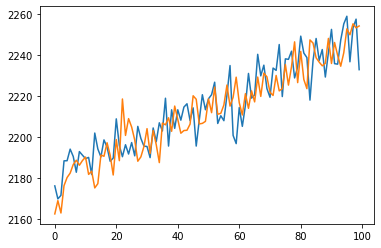

RMSE: 5.317911
r2: 0.999777


In [14]:
Model(df_model).evaluate()

In [16]:
df = bitdata.filter("type = \"ETHUSD\"").filter("timestamp >= \"2022-01-01\"").withColumn("close", bitdata.close.cast('float'))
df = df.withColumn("timestamp",func.to_timestamp("timestamp")).sort("timestamp")
df_model = df.select("timestamp", "close")
pred_eth = Model(df_model).forecast(100)

forcast on 2022-04-08 04:07:00: 3269.61777751819
forcast on 2022-04-08 04:08:00: 3269.5159100495457
forcast on 2022-04-08 04:09:00: 3269.258158294812
forcast on 2022-04-08 04:10:00: 3269.0509743330695
forcast on 2022-04-08 04:11:00: 3268.8320672057794
forcast on 2022-04-08 04:12:00: 3268.7846388404714
forcast on 2022-04-08 04:13:00: 3268.7256037616125
forcast on 2022-04-08 04:14:00: 3268.692259334201
forcast on 2022-04-08 04:15:00: 3268.6518700738
forcast on 2022-04-08 04:16:00: 3268.543743955288
forcast on 2022-04-08 04:17:00: 3268.5228399365765
forcast on 2022-04-08 04:18:00: 3268.4399859430832
forcast on 2022-04-08 04:19:00: 3268.3563019575013
forcast on 2022-04-08 04:20:00: 3268.2783768702343
forcast on 2022-04-08 04:21:00: 3268.2040876111064
forcast on 2022-04-08 04:22:00: 3268.1357172969488
forcast on 2022-04-08 04:23:00: 3268.0668107381034
forcast on 2022-04-08 04:24:00: 3267.997779572884
forcast on 2022-04-08 04:25:00: 3267.927542475435
forcast on 2022-04-08 04:26:00: 3267.8561

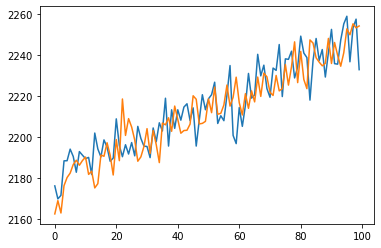

RMSE: 5.317911
r2: 0.999777


In [17]:
Model(df_model).evaluate()

In [18]:
df = bitdata.filter("type = \"LTCUSD\"").filter("timestamp >= \"2022-01-01\"").withColumn("close", bitdata.close.cast('float'))
df = df.withColumn("timestamp",func.to_timestamp("timestamp")).sort("timestamp")
df_model = df.select("timestamp", "close")
pred_ltc = Model(df_model).forecast(100)

forcast on 2022-04-08 04:08:00: 114.60713177765244
forcast on 2022-04-08 04:09:00: 114.62286085544656
forcast on 2022-04-08 04:10:00: 114.63858144434982
forcast on 2022-04-08 04:11:00: 114.65432927012029
forcast on 2022-04-08 04:12:00: 114.67016482805965
forcast on 2022-04-08 04:13:00: 114.68611289047735
forcast on 2022-04-08 04:14:00: 114.70987581220928
forcast on 2022-04-08 04:15:00: 114.73527870955887
forcast on 2022-04-08 04:16:00: 114.76456831710118
forcast on 2022-04-08 04:17:00: 114.78634441769827
forcast on 2022-04-08 04:18:00: 114.80940217501853
forcast on 2022-04-08 04:19:00: 114.83035037431755
forcast on 2022-04-08 04:20:00: 114.85144458350878
forcast on 2022-04-08 04:21:00: 114.87272713766329
forcast on 2022-04-08 04:22:00: 114.89424503180722
forcast on 2022-04-08 04:23:00: 114.91604786468477
forcast on 2022-04-08 04:24:00: 114.93819316591176
forcast on 2022-04-08 04:25:00: 114.96025703011055
forcast on 2022-04-08 04:26:00: 114.98212965018946
forcast on 2022-04-08 04:27:00:

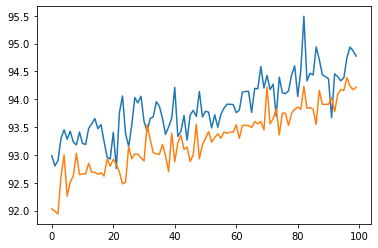

RMSE: 0.362862
r2: 0.999334


In [19]:
Model(df_model).evaluate()

In [20]:
def pretrain(type):
  if type == "BTCUSD":
    return pred_btc
  elif type == "ETHUSD":
    return pred_eth
  if type == "LTCUSD":
    return pred_ltc

In [ ]:
from IPython.display import display, clear_output, Markdown
from ipywidgets import IntSlider
from itertools import chain
import ipywidgets as widgets

users = widgets.Dropdown(
    options=bit2021.select("type").distinct().toPandas()["type"].tolist(),
    value="BTCUSD",
    description='Crypotocurrency:',
    style = {'description_width': 'initial'},
    disabled=False)
calendar1 = widgets.DatePicker(
           description='Start Date',
           )
calendar2 = widgets.DatePicker(
           description='End Date')
          # value="2021-03-01")
ma = widgets.Checkbox(
    value=False,
    description='Show Moving Average',
    disabled=False,
    indent=False
)
nDayMA = widgets.Dropdown(
    options=[20, 50, 300],
    description='N-Unit Moving Average:',
    style = {'description_width': 'initial'},
    disabled=False)
nDayPred = widgets.BoundedIntText(
    value=7,
    min=1,
    max=9999,
    step=1,
    description='N-Unit Prediction:',
    style = {'description_width': 'initial'},
    disabled=False
)
buttonuser_info = widgets.Button(description='Load Data')
outuser_info = widgets.Output()
def on_buttonuser_info_clicked(b):
  with outuser_info:
        clear_output()
        plt.ion()
        cptype = bitdata.filter("type =  \"" + str(users.value) + "\"")
        ctype = cptype.filter("timestamp >= \"" + str(calendar1.value) + "\"").filter("timestamp <= \"" + str(calendar2.value) + "\"")
        ts = ctype.select("timestamp").toPandas()["timestamp"].tolist()
        fig = make_subplots(rows=2, cols=2)
        # Price - Line
        fig.add_trace(go.Scatter(x =ts,
               y=list(chain(*ctype.select(col("close").cast("double").alias("close")).toPandas().values.tolist())),
               mode="lines", name = "Price (in minute)",
               showlegend =True, line=dict(color="red", width=4)),
            row=1, col=1)
        if ma.value:
          addma = calculate_ma(ctype, nDayPred.value)
          fig.add_trace(go.Scatter(x =ts,
               y=list(chain(*addma.select(col("MA").cast("double").alias("MA")).toPandas().values.tolist())),
               mode="lines", name="Moving Average", showlegend =True, line=dict(color="blue", width=2)),
            row=1, col=1)
        # Price - Candlestick
        fig.add_trace(go.Candlestick(x=ts,
                       open  = list(chain(*ctype.select(col("open").cast("double").alias("open")).toPandas().values.tolist())),
                       high  = list(chain(*ctype.select(col("high").cast("double").alias("high")).toPandas().values.tolist())),
                       low   = list(chain(*ctype.select(col("low").cast("double").alias("low")).toPandas().values.tolist())),
                       close = list(chain(*ctype.select(col("close").cast("double").alias("close")).toPandas().values.tolist())),
                       showlegend =False),
            row=2, col=2)
        # Volume in hour
        agg = agg_n_unit(cptype, 1440)
        fig.add_trace(go.Bar(x=agg.select("timestamp").toPandas()["timestamp"].tolist(),
                     y=list(chain(*agg.select(col("sum(Volume)").cast("double").alias("volume")).toPandas().values.tolist())),
              marker_color='black', showlegend =False
              ),
              row=2, col=1)
        # Price Prediction
        ptype = cptype.filter("timestamp >= \"2022-04-07\"")
        fig.add_trace(go.Scatter(x=ptype.select("timestamp").toPandas()["timestamp"].tolist(),
               y=list(chain(*ptype.select(col("close").cast("double").alias("close")).toPandas().values.tolist())),
               mode="lines", showlegend =True, name = "Historical", line=dict(color="blue", width=1)),
            row=1, col=2)
        
        pred = pretrain(users.value)
        fig.add_trace(go.Scatter(x=pred.select("timestamp").limit(nDayPred.value).toPandas()["timestamp"].tolist(),
               y=list(chain(*pred.select(col("prediction").cast("double").alias("prediction")).limit(nDayPred.value).toPandas().values.tolist())),
               mode="lines", showlegend =True, name="Forecasting", line=dict(color="orange", width=1)),
            row=1, col=2)
      
        fig.update_layout(width=1200, height=750, 
                          title = "Cryptocurrencies Overview")
        fig.show()
        
buttonuser_info.on_click(on_buttonuser_info_clicked)
display(widgets.VBox([users, calendar1, calendar2, ma, nDayMA, nDayPred, buttonuser_info, outuser_info]))

In [ ]:
bitdata.filter("type = \"BTCUSD\"")